# Using only OpenCV

1) Load the Image. 
2) Make it Grayscaled. 
3) Apply Binary Thresholding. 
4) Use OpenCVs Dilution function to ensure that the blobs are clear and disctinct. 
5) Use OpenCVs contour detection, filter the contours which are rectangular in shape and choose the biggest rectange to detect the table. 

Concepts used 
1) Computing Homography & Perspective Transformation
2) Canny Edge Detection 
3) Hough Transform for line detection 
4) Grayscaling and Thresholding Images

In [1]:
import cv2
import matplotlib.pyplot as plt
import re
from image_config import * 

In [49]:
IMAGE_PATH_1 = './../Demo_Image_1.png'
IMAGE_PATH_2 = './../images/table_image_2.png'
IMAGE_PATH = './../images/single-info.png'
IMAGE_PATH_3 = './../images/demo_image_opencv.jpg'

In [50]:
image = cv2.imread(IMAGE_PATH)
image_copy = image.copy()
# image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

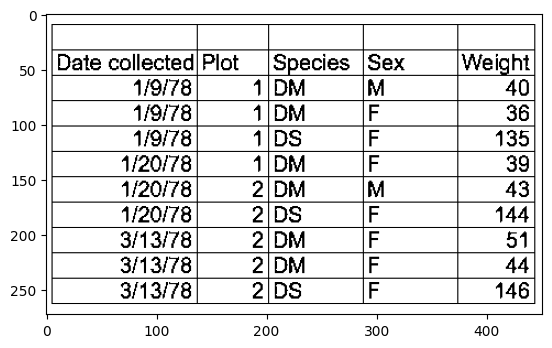

In [51]:
binary_demo_img = binarized_image(image)
inverted_binary_demo_img = invert_image(binary_demo_img)
plt.imshow(inverted_binary_demo_img,cmap = 'gray')

In [52]:
contours,image_with_contours = find_and_draw_contours_in_image(image)

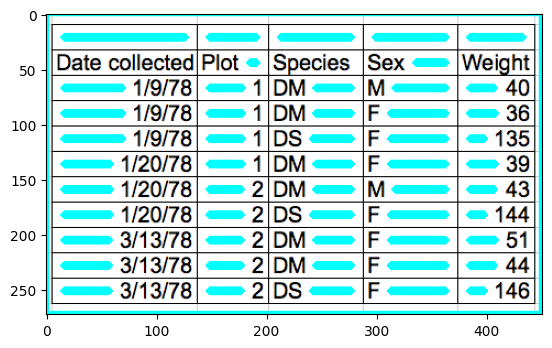

In [53]:
plt.imshow(image_with_contours)

In [54]:
rectangular_contours , image_with_only_rectangular_contours = filter_and_draw_rectangular_contours(image,contours,epsilon_factor = 0.16)

In [55]:
rectangular_contours

[array([[[  0,   0]],
 
        [[  0, 272]],
 
        [[450, 272]],
 
        [[450,   0]]], dtype=int32),
 array([[[312, 251]],
 
        [[363, 250]],
 
        [[364, 252]],
 
        [[313, 253]]], dtype=int32),
 array([[[312, 228]],
 
        [[363, 227]],
 
        [[364, 229]],
 
        [[313, 230]]], dtype=int32),
 array([[[312, 205]],
 
        [[363, 204]],
 
        [[364, 206]],
 
        [[313, 207]]], dtype=int32),
 array([[[312, 182]],
 
        [[363, 181]],
 
        [[364, 183]],
 
        [[313, 184]]], dtype=int32),
 array([[[316, 159]],
 
        [[363, 158]],
 
        [[364, 160]],
 
        [[317, 161]]], dtype=int32),
 array([[[312, 136]],
 
        [[363, 135]],
 
        [[364, 137]],
 
        [[313, 138]]], dtype=int32),
 array([[[312, 113]],
 
        [[363, 112]],
 
        [[364, 114]],
 
        [[313, 115]]], dtype=int32),
 array([[[ 15, 113]],
 
        [[ 69, 112]],
 
        [[ 70, 114]],
 
        [[ 16, 115]]], dtype=int32),
 array([[[312,  90]

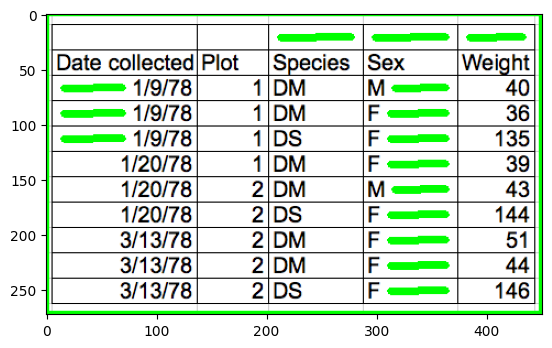

In [56]:
plt.imshow(image_with_only_rectangular_contours)

In [57]:
image_with_only_largest_contour, contour_with_max_area = (find_largest_contour(image,rectangular_contours))

[[[  0   0]]

 [[  0 272]]

 [[450 272]]

 [[450   0]]]
max contour is [[[  0   0]]

 [[  0 272]]

 [[450 272]]

 [[450   0]]]
[[[312 251]]

 [[363 250]]

 [[364 252]]

 [[313 253]]]
max contour is [[[  0   0]]

 [[  0 272]]

 [[450 272]]

 [[450   0]]]
[[[312 228]]

 [[363 227]]

 [[364 229]]

 [[313 230]]]
max contour is [[[  0   0]]

 [[  0 272]]

 [[450 272]]

 [[450   0]]]
[[[312 205]]

 [[363 204]]

 [[364 206]]

 [[313 207]]]
max contour is [[[  0   0]]

 [[  0 272]]

 [[450 272]]

 [[450   0]]]
[[[312 182]]

 [[363 181]]

 [[364 183]]

 [[313 184]]]
max contour is [[[  0   0]]

 [[  0 272]]

 [[450 272]]

 [[450   0]]]
[[[316 159]]

 [[363 158]]

 [[364 160]]

 [[317 161]]]
max contour is [[[  0   0]]

 [[  0 272]]

 [[450 272]]

 [[450   0]]]
[[[312 136]]

 [[363 135]]

 [[364 137]]

 [[313 138]]]
max contour is [[[  0   0]]

 [[  0 272]]

 [[450 272]]

 [[450   0]]]
[[[312 113]]

 [[363 112]]

 [[364 114]]

 [[313 115]]]
max contour is [[[  0   0]]

 [[  0 272]]

 [[450 272]]

In [58]:
reshaped_contour_with_max_area = contour_with_max_area.reshape(4,2)

In [59]:
reshaped_contour_with_max_area

array([[  0,   0],
       [  0, 272],
       [450, 272],
       [450,   0]], dtype=int32)

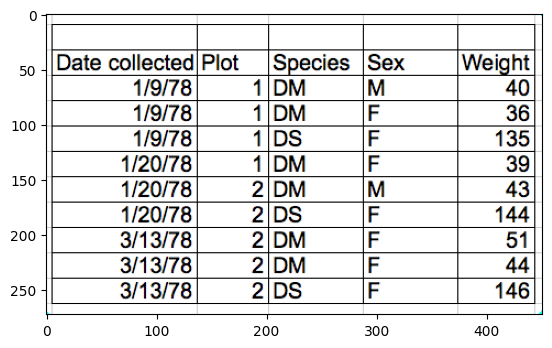

In [60]:
plt.imshow(image_with_only_largest_contour)

In [61]:
ordered_points = order_rectangle_points(reshaped_contour_with_max_area)
pt_A, pt_B, pt_C, pt_D = ordered_points

In [62]:
point_labels = ['Point A', 'Point B', 'Point C', 'Point D']  # Labels for each pointfor point in ordered_points:
image = image_with_only_largest_contour.copy()
for point, label in zip(ordered_points, point_labels):
    center_coordinates = point
    radius = 15  # Radius of circle
    color = (0, 255, 0)  # Circle color, green in this case
    thickness = 2  # Thickness of the circle line. Use -1 for filling the circle
    image = cv2.circle(image, center_coordinates, radius, color, thickness)
    # Text parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (255, 0, 0)  # Blue color for the text
    font_thickness = 1
    text_offset_x, text_offset_y = 10, -10  # Offset from the circle center to start the text

    # Put the text label
    image = cv2.putText(image, label, (center_coordinates[0] + text_offset_x, center_coordinates[1] + text_offset_y),
                        font, font_scale, font_color, font_thickness)


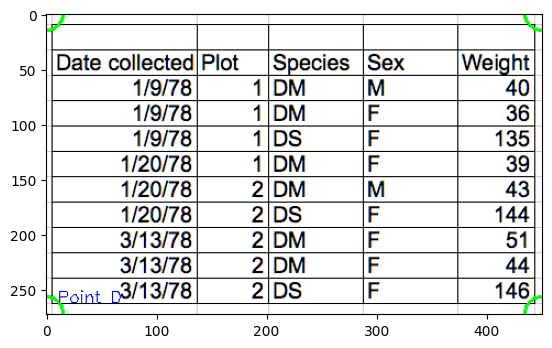

In [63]:
plt.imshow(cv2.cvtColor(image,cv2.COLOR_RGB2BGR))

In [64]:
ordered_points

[array([0, 0], dtype=int32),
 array([450,   0], dtype=int32),
 array([450, 272], dtype=int32),
 array([  0, 272], dtype=int32)]

## Perspective Transformation by computing the homography

In [65]:
width_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
width_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxWidth = max(int(width_AB), int(width_CD))
 
height_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
height_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxHeight = max(int(height_AD), int(height_BC))

In [66]:
maxWidth

450

In [67]:
perspective_points = np.float32([[0, 0],
                        [maxWidth ,0],
                        [maxWidth , maxHeight ],
                        [0,maxHeight ]])

In [68]:
input_pts = np.float32(list(ordered_points))

In [69]:
input_pts

array([[  0.,   0.],
       [450.,   0.],
       [450., 272.],
       [  0., 272.]], dtype=float32)

In [70]:
perspective_points

array([[  0.,   0.],
       [450.,   0.],
       [450., 272.],
       [  0., 272.]], dtype=float32)

In [71]:
M = cv2.getPerspectiveTransform(input_pts,perspective_points)

In [72]:
M

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [73]:
image_with_only_largest_contour_BGR = cv2.cvtColor(image_with_only_largest_contour,cv2.COLOR_RGB2BGR)

In [74]:
out = cv2.warpPerspective(image_with_only_largest_contour_BGR,M,(maxWidth,maxHeight),flags=cv2.INTER_LINEAR)
image_copy = out.copy()

In [75]:
type(out)

numpy.ndarray

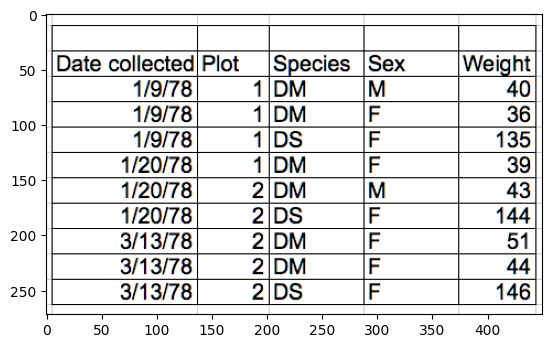

In [76]:
plt.imshow(out)

### Find all Horizontal Lines using Canny Edge detection followed by Hough Transformation and filtration
#### Did not work

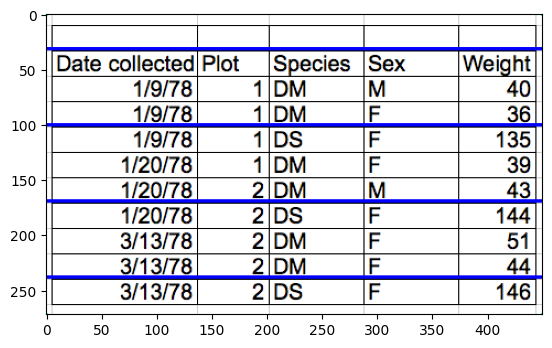

In [77]:
images_with_horizontal_lines = find_lines(out,threshold = 600)
plt.imshow( cv2.cvtColor(images_with_horizontal_lines,cv2.COLOR_RGB2BGR))

In [78]:
out_cv_compatible = convert_to_opencv_format(out)

### Filter These Lines from the Binarized Image

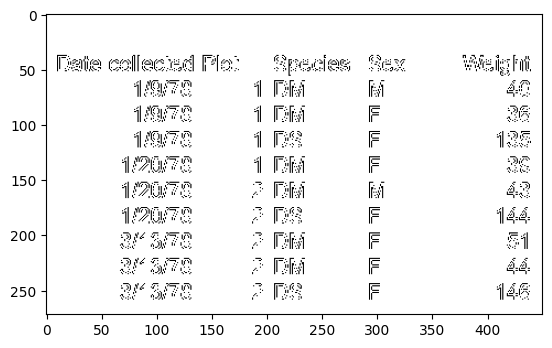

In [79]:
binary_image = binarized_image(out_cv_compatible)
plt.imshow(binary_image, cmap = 'gray')

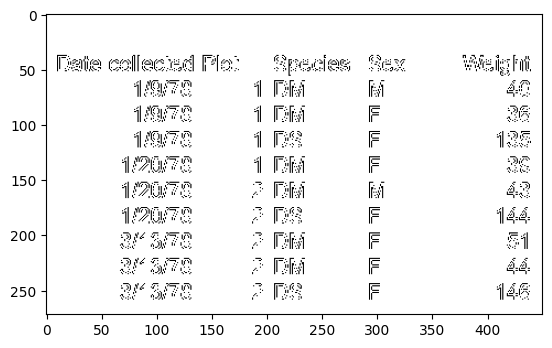

In [80]:
bin_image = erase_lines_from_binarized_image(binary_image, line_type='both',threshold = 40000)
plt.imshow(bin_image,cmap = 'gray')

### Find all Horizontal Lines using Canny Edge detection followed by Hough Transformation and filtration using erosion

In [81]:
inverted_image = invert_image(bin_image)

In [82]:
image_without_tabular_lines = subtract_combined_and_dilated_image_from_original_image(inverted_image,combine_eroded_images(erode_vertical_lines(inverted_image),erode_horizontal_lines(inverted_image)))

### Removing noisy white borders using Erosion and Dilation

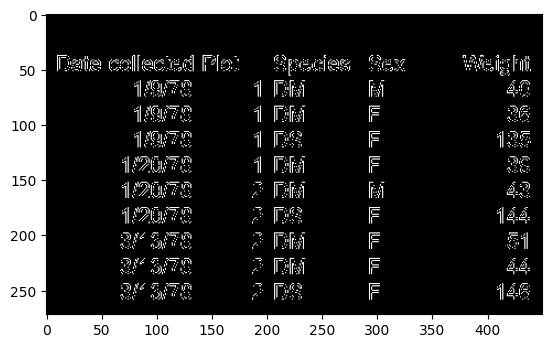

In [83]:
plt.imshow(image_without_tabular_lines,cmap = 'gray')

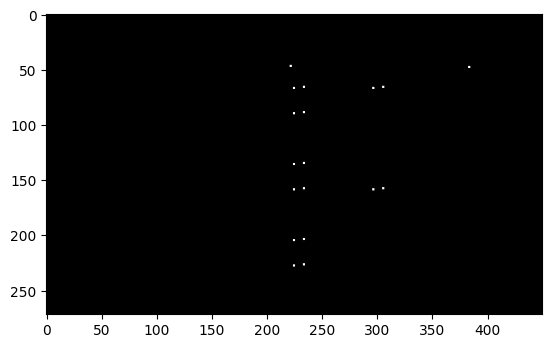

In [84]:
cleaned_image =  remove_noisy_line_borders_from_image(image_without_tabular_lines)
plt.imshow(cleaned_image,cmap = 'gray')

image is inverted


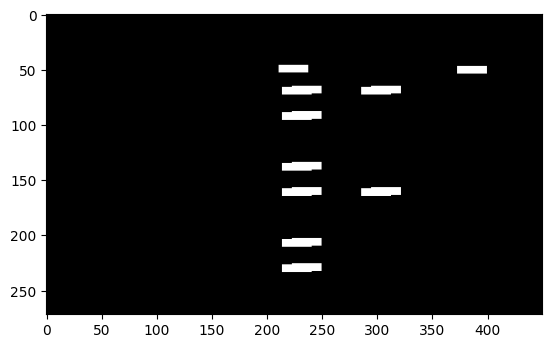

In [85]:
dilated_cleaned_image = dilate_image(cleaned_image,kernel_size = np.array([[1,1,1,1,1,1],[1,1,1,1,1,1]], np.uint8),inverted = True)
plt.imshow(dilated_cleaned_image,cmap = 'gray')

In [86]:
contours,heirarchy = find_contours_on_image(dilated_cleaned_image,image_dilated = True)
image_with_contours = draw_contour_on_image(image_copy,contours)
# rectangular_contours = filter_rectangular_contours(image_copy,contours,epsilon_factor = 0.001)

In [87]:
image_copy_2  = image_copy.copy()

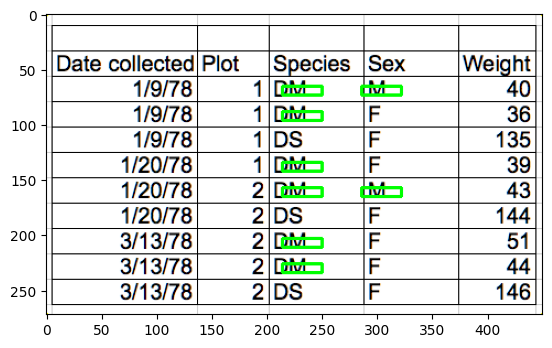

In [88]:
# Loop through the contours
bounding_boxes = []
min_area_of_box = 270
for cnt in contours:
    # Get the bounding box for each contour
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    if area >= min_area_of_box:
        bounding_boxes.append((x, y, w, h))
    # Draw the bounding box on the original image
        cv2.rectangle(image_copy_2, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
# Sort bounding boxes based on their x and then y values
sorted_bounding_boxes = sorted(bounding_boxes, key=lambda b: (b[0], b[1]))

# Display the image with bounding boxes
plt.imshow(image_copy_2)

In [89]:
mean_height = get_mean_height_of_bounding_boxes(sorted_bounding_boxes)
bounding_boxes = sort_bounding_boxes_by_y_coordinate(bounding_boxes)
current_row = [bounding_boxes[0]]
rows = club_all_bounding_boxes_by_similar_y_coordinates_into_rows(mean_height,bounding_boxes,current_row)

In [43]:
rows

[[(152, 36, 532, 40)],
 [(117, 84, 601, 47)],
 [(45, 153, 166, 41), (567, 155, 226, 40)],
 [(44, 221, 334, 40), (641, 222, 151, 48)],
 [(45, 288, 246, 41), (640, 289, 152, 48)],
 [(640, 356, 152, 47), (44, 356, 82, 39)],
 [(661, 423, 131, 47), (45, 423, 173, 40)],
 [(605, 489, 186, 47), (44, 489, 164, 42)],
 [(639, 555, 152, 48), (44, 557, 465, 41)],
 [(683, 622, 108, 47), (43, 624, 379, 41)]]

In [44]:
sorted_rows = sort_all_rows_by_x_coordinate(rows)

In [48]:
sorted_rows

[[(152, 36, 532, 40)],
 [(117, 84, 601, 47)],
 [(45, 153, 166, 41), (567, 155, 226, 40)],
 [(44, 221, 334, 40), (641, 222, 151, 48)],
 [(45, 288, 246, 41), (640, 289, 152, 48)],
 [(44, 356, 82, 39), (640, 356, 152, 47)],
 [(45, 423, 173, 40), (661, 423, 131, 47)],
 [(44, 489, 164, 42), (605, 489, 186, 47)],
 [(44, 557, 465, 41), (639, 555, 152, 48)],
 [(43, 624, 379, 41), (683, 622, 108, 47)]]

In [45]:
current_row[-1][1]

36

In [46]:
print(rows)

[[(152, 36, 532, 40)], [(117, 84, 601, 47)], [(45, 153, 166, 41), (567, 155, 226, 40)], [(44, 221, 334, 40), (641, 222, 151, 48)], [(45, 288, 246, 41), (640, 289, 152, 48)], [(44, 356, 82, 39), (640, 356, 152, 47)], [(45, 423, 173, 40), (661, 423, 131, 47)], [(44, 489, 164, 42), (605, 489, 186, 47)], [(44, 557, 465, 41), (639, 555, 152, 48)], [(43, 624, 379, 41), (683, 622, 108, 47)]]


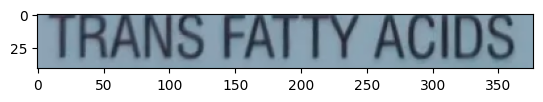

In [47]:
image_cropped = image_copy[624:665,43:420,]
plt.imshow(image_cropped)

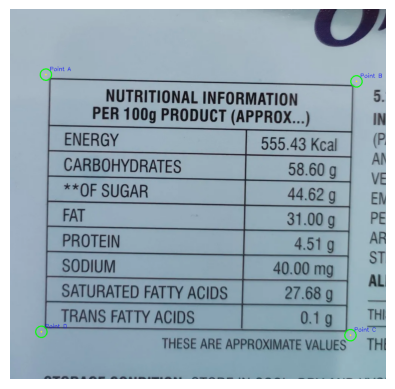

In [47]:
# Load an OpenCV image

# Check if the image was loaded successfully
if image is not None:
    # Convert BGR to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()
else:
    print("Failed to load the image.")

In [48]:
img_cv = image.copy()
img_resized = cv2.resize(img_cv,
                         (int(img_cv.shape[1] + (img_cv.shape[1] * .1)),
                          int(img_cv.shape[0] + (img_cv.shape[0] * .25))),
                         interpolation=cv2.INTER_AREA) 
img_rgb = cv2.cvtColor(img_resized,cv2.COLOR_BGR2RGB)

## Grayscale Conversion

In [49]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
len(gray_image.shape)

2

In [50]:
dilated_image = dilate_image(gray_image)

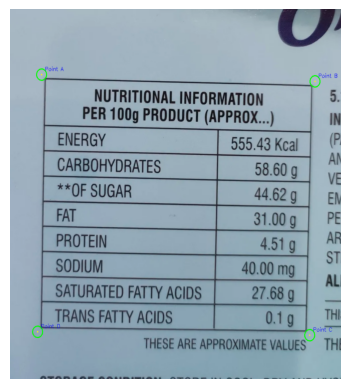

In [51]:
# Display the binarized image using matplotlib
plt.imshow(img_rgb, cmap='gray')  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

## Image Binarization to convert it to black and white 

In [52]:
_, binarized_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

In [53]:
cv2.imwrite('processed_image.jpg', binarized_image)

True

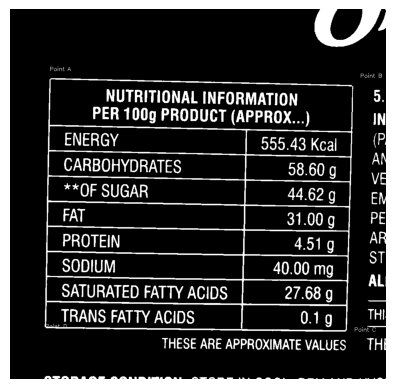

In [54]:
# Display the binarized image using matplotlib
plt.imshow(binarized_image, cmap='gray')  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# Using tesseract

In [55]:
import pytesseract 
from pytesseract import image_to_string

In [56]:
extracted_text = image_to_string(binarized_image)

In [57]:
from pytesseract import image_to_string
extracted_text = image_to_string(binarized_image)

In [58]:
extracted_text

''

### Verify what has been Extracted 

In [59]:
with open('output.txt', 'w') as file:
    file.write(extracted_text)

### Setup Excel

In [60]:
from openpyxl import Workbook


In [61]:
wb = Workbook()
ws = wb.active

In [62]:
rows = extracted_text.strip().split('\n')

In [63]:
rows

['']

In [64]:
for r_index, row in enumerate(rows, start=1):
    columns = re.split(r'[|\t]+', row) if r_index == 1 else re.split(r'[|\t\s]+', row)
    print(columns)
    for c_index, cell_value in enumerate(columns, start=1):
        ws.cell(row=r_index, column=c_index, value=cell_value.strip())

['']


In [65]:
columns

['']

In [66]:
wb.save('output.xlsx')

In [67]:
from image_config import *

In [68]:
dilated_image = dilate_image(image)